In [1]:
%matplotlib inline
import os
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from torch.utils.data import DataLoader

In [2]:
# From local helper files
from helper_evaluation import set_all_seeds, set_deterministic, compute_confusion_matrix
from helper_train import train_model
from helper_plotting import plot_training_loss, plot_accuracy, show_examples, plot_confusion_matrix
from helper_dataset import get_dataloaders_cifar10, UnNormalize

In [6]:
class MyDataset(Dataset):

    def __init__(self, csv_path, transform=None):
    
        df = pd.read_csv(csv_path)
        self.img_dir = df["File Directory"]
        self.img_names = df['File Name']
        self.y = df['Class Label']
        self.transform = transform

    def __getitem__(self, index):
        img = Image.open(os.path.join(self.img_dir[index],
                                      self.img_names[index]))
        
        if self.transform is not None:
            img = self.transform(img)
        
        label = self.y[index]
        return img, label

    def __len__(self):
        return self.y.shape[0]

In [7]:
##########################
### SETTINGS
##########################

RANDOM_SEED = 123
BATCH_SIZE = 128
NUM_EPOCHS = 50

set_all_seeds(RANDOM_SEED)
#set_deterministic()

DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


In [8]:
custom_transform_mask = transforms.Compose([#transforms.Lambda(lambda x: x/255.), # not necessary
    transforms.Resize((70, 70)),
    torchvision.transforms.RandomCrop((64, 64)),
    transforms.ToTensor(),
    torchvision.transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ])


train_dataset_mask = MyDataset(csv_path='df_train.csv',
                          transform=custom_transform_mask)

train_loader_mask = DataLoader(dataset=train_dataset_mask,
                          batch_size=BATCH_SIZE,
                          drop_last=True,
                          shuffle=True, # want to shuffle the dataset
                          num_workers=0) # number processes/CPUs to use


valid_dataset_mask = MyDataset(csv_path='df_val.csv',
                          transform=custom_transform_mask)

valid_loader_mask = DataLoader(dataset=valid_dataset_mask,
                          batch_size=BATCH_SIZE,
                          shuffle=True,
                          num_workers=0)


test_dataset_mask = MyDataset(csv_path='df_test.csv',
                         transform=custom_transform_mask)

test_loader_mask = DataLoader(dataset=test_dataset_mask,
                         batch_size=BATCH_SIZE,
                         shuffle=True,
                         num_workers=0)

In [9]:
# Checking the dataset
for images, labels in train_loader_mask:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    print('Class labels of 10 examples:', labels[:10])
    break

Image batch dimensions: torch.Size([128, 3, 64, 64])
Image label dimensions: torch.Size([128])
Class labels of 10 examples: tensor([0, 1, 1, 1, 1, 1, 0, 1, 1, 0])


# Transferlearning -- VGG-16

### Load Pre-Trained Model

In [10]:
model = torchvision.models.vgg16(pretrained=True)
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

### Freezing the Model

In [11]:
for param in model.parameters():
    param.requires_grad = False

Assume we want to fine-tune (train) the last 3 layers:

In [12]:
# Assume we want to fine-tune (train) the last 3 layers:
model.classifier[1].requires_grad = True
model.classifier[3].requires_grad = True

For the last layer, because the number of class labels differs compared to ImageNet, we replace the output layer with your own output layer:

In [13]:
model.classifier[6] = torch.nn.Linear(4096, 2)

## vgg16

Epoch: 001/050 | Batch 0000/0078 | Loss: 0.9681
Epoch: 001/050 | Train: 99.24% | Validation: 99.12%
Time elapsed: 0.90 min
Epoch: 002/050 | Batch 0000/0078 | Loss: 0.6829
Epoch: 002/050 | Train: 99.48% | Validation: 99.38%
Time elapsed: 1.77 min
Epoch: 003/050 | Batch 0000/0078 | Loss: 0.0516
Epoch: 003/050 | Train: 99.41% | Validation: 99.25%
Time elapsed: 2.65 min
Epoch: 004/050 | Batch 0000/0078 | Loss: 0.3525
Epoch: 004/050 | Train: 99.63% | Validation: 99.75%
Time elapsed: 3.52 min
Epoch: 005/050 | Batch 0000/0078 | Loss: 2.0991
Epoch: 005/050 | Train: 99.60% | Validation: 99.75%
Time elapsed: 4.40 min
Epoch: 006/050 | Batch 0000/0078 | Loss: 0.0851
Epoch: 006/050 | Train: 99.54% | Validation: 99.88%
Time elapsed: 5.27 min
Epoch: 007/050 | Batch 0000/0078 | Loss: 1.5991
Epoch: 007/050 | Train: 99.66% | Validation: 99.62%
Time elapsed: 6.14 min
Epoch: 008/050 | Batch 0000/0078 | Loss: 1.1987
Epoch: 008/050 | Train: 99.67% | Validation: 99.50%
Time elapsed: 7.03 min
Epoch: 009/050 |

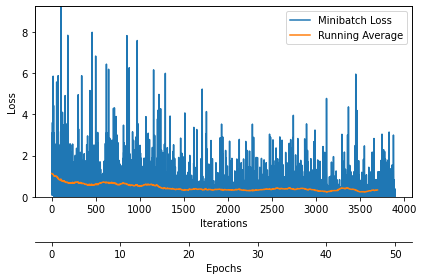

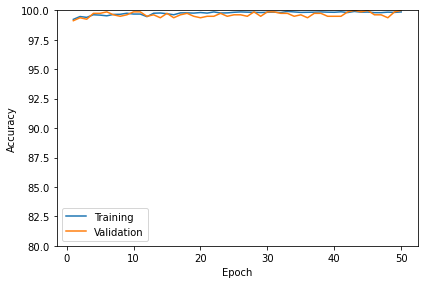

In [14]:
model = model.to(DEVICE)

optimizer = torch.optim.SGD(model.parameters(), momentum=0.9, lr=0.1)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                       factor=0.1,
                                                       mode='max',
                                                       verbose=True)

minibatch_loss_list, train_acc_list, valid_acc_list = train_model(
    model=model,
    num_epochs=NUM_EPOCHS,
    train_loader=train_loader_mask,
    valid_loader=valid_loader_mask,
    test_loader=test_loader_mask,
    optimizer=optimizer,
    device=DEVICE,
    scheduler=scheduler,
    scheduler_on='valid_acc',
    logging_interval=100)

plot_training_loss(minibatch_loss_list=minibatch_loss_list,
                   num_epochs=NUM_EPOCHS,
                   iter_per_epoch=len(train_loader_mask),
                   results_dir=None,
                   averaging_iterations=200)
plt.show()

plot_accuracy(train_acc_list=train_acc_list,
              valid_acc_list=valid_acc_list,
              results_dir=None)
plt.ylim([80, 100])
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

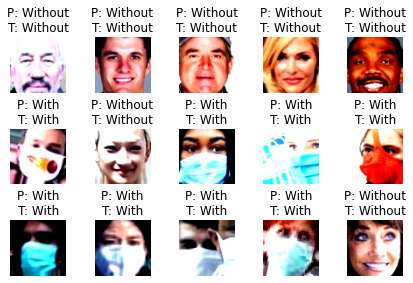

In [15]:
model.cpu()
unnormalizer = UnNormalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
class_dict = {0: 'Without',
              1: 'With'
              }

show_examples(model=model, data_loader=test_loader_mask, unnormalizer=unnormalizer, class_dict=class_dict)

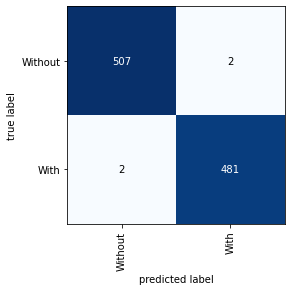

In [16]:
mat = compute_confusion_matrix(model=model, data_loader=test_loader_mask, device=torch.device('cpu'))
plot_confusion_matrix(mat, class_names=class_dict.values())
plt.show()